In [127]:
import os
import urllib
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import lightgbm as lgb
import matplotlib.pyplot as plt

from typing import Optional, Tuple, List

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

## 1) Dowload the data

In [128]:
REPO_URL = "https://github.com/SpikeLab-CL/challenge_watershed/raw/main/flux.csv.zip"
ZIP_FILE = "flux.csv.zip"
UNCOMPRESSED_NAME = "flux.csv"

In [129]:
def get_data(repo_url: str, dowload_name: str = "flux.csv.zip") -> None:
    """ Fetch the data from github repo
    
    Parameters
    ----------
    repo_url: str
        Url of the zip file to be stract and decompress

    dowload_name: str
        Name of the dowloaded object in the data_folder, defaults to "flux.csv.zip" 

    Returns
    ----------
    None
    """

    urllib.request.urlretrieve(repo_url, dowload_name)

    

def load_data(zip_file: str, uncompressed_name: Optional[str] = None) -> pd.DataFrame:
    """ Load the data from an existen file in the project (zip format)

    Parameters
    ----------
    
    zip_file: str
        Name of the file that it´s needed

    uncompresed_name: Optional[str]
        Name of the uncompressed zip file (must be in csv format)

    Returns
    ----------
    pd.DataFrame
        Data in DataFrame format  
    """

    with zipfile.ZipFile(zip_file) as zip_file:
        zip_file.extractall()

    if uncompressed_name is not None:
        data = pd.read_csv(uncompressed_name)

        # Give some format to the date columns
        data["date"] = pd.to_datetime(data.date, format= "%Y-%m-%d")

        return data

In [130]:
get_data(REPO_URL)

In [131]:
data = load_data(ZIP_FILE, UNCOMPRESSED_NAME)

## 2) EDA

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   basin_id    int64         
 2   flux        float64       
 3   precip      float64       
 4   temp_max    float64       
 5   gauge_name  object        
 6   lat         float64       
 7   lon         float64       
 8   mean_elev   float64       
 9   area_km2    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 318.9+ MB


In [133]:
data.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [134]:
data.describe()

,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2
count,4.180480e+06,4.180480e+06,4.175037e+06,4.175037e+06,4.180480e+06,4.180480e+06,4.180480e+06,4.180480e+06
mean,7.179757e+06,5.253340e+01,2.947445e+00,1.365728e+01,-3.569572e+01,-7.129595e+01,1.760129e+03,2.404876e+03
std,3.180965e+06,1.676027e+02,8.766749e+00,6.615037e+00,8.047659e+00,1.254339e+00,1.382121e+03,4.322051e+03
min,1.001001e+06,0.000000e+00,0.000000e+00,-1.160359e+01,-5.494690e+01,-7.366670e+01,1.181229e+02,1.789123e+01
25%,4.558001e+06,8.680000e-01,0.000000e+00,9.162867e+00,-3.915000e+01,-7.231670e+01,5.847012e+02,3.761001e+02
50%,7.350003e+06,5.171000e+00,0.000000e+00,1.321396e+01,-3.588420e+01,-7.137190e+01,1.195311e+03,8.205541e+02
75%,9.416001e+06,2.990000e+01,6.422626e-01,1.805745e+01,-3.126560e+01,-7.050670e+01,3.048161e+03,2.461610e+03
max,1.293000e+07,1.580500e+04,2.132120e+02,4.081117e+01,-1.784280e+01,-6.763920e+01,4.910152e+03,5.224367e+04


In [135]:
data.gauge_name.value_counts().sort_values(ascending=False)

Rio Aconcagua En Chacabuquito                   14670
Rio Cruces En Rucaco                            14649
Rio Choapa En Cuncumen                          14639
Rio Elqui En Algarrobal                         14634
Rio Cautin En Cajon                             14603
                                                ...  
Estero Chimbarongo En Santa Cruz                  328
Rio Chillan En Longitudinal                       302
Rio Pama Entrada Embalse Cogoti                   195
Estero Las Vegas Aguas Abajo Canal Las Vegas      195
Rio Blanco En Chaiten                             175
Name: gauge_name, Length: 503, dtype: int64

In [136]:
gauge_split = (
    data
    .gauge_name
    .str.split(" ")
    .str[0]
    )

In [137]:
gauge_split.value_counts().sort_values(ascending=False)

Rio          3847159
Estero        299612
Quebrada       14941
Q.             12652
Captacion       3376
Zanjon          2740
Name: gauge_name, dtype: int64

In [138]:
data.isna().mean().sort_values(ascending=False)

precip        0.001302
temp_max      0.001302
date          0.000000
basin_id      0.000000
flux          0.000000
gauge_name    0.000000
lat           0.000000
lon           0.000000
mean_elev     0.000000
area_km2      0.000000
dtype: float64

In [139]:
data.dropna(inplace=True)

<AxesSubplot:ylabel='Frequency'>

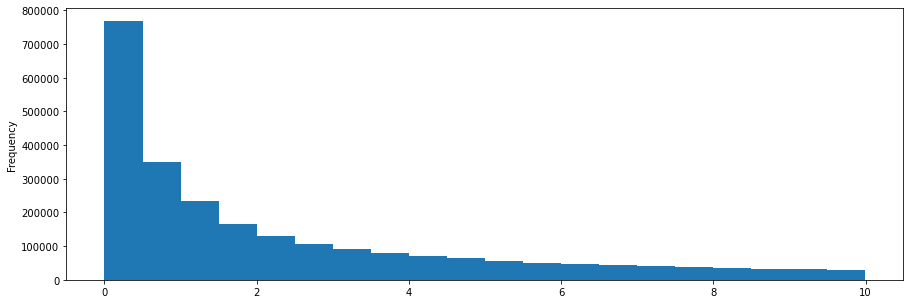

In [140]:
data.flux[data.flux.lt(10)].plot(kind="hist", figsize= (15,5), bins= 20)

<AxesSubplot:ylabel='Frequency'>

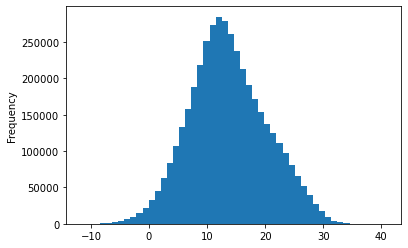

In [141]:
data.temp_max.plot(kind= "hist", bins = 50)

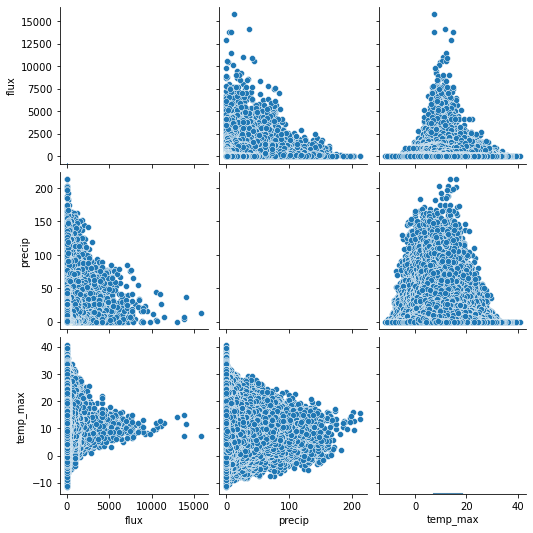

In [79]:
sns.pairplot(data[["flux", "precip", "temp_max"]])

The variables are within the expected ranges, the most interesting is perhaps the relationships that can be observed in the pairplot, where it can be seen that high flux values are seen in times of moderate temperatures (around 10 degrees) and that the flux also increases normally when there are moderate levels of precipitation (not extreme).

## 3)  Plot flux, temperature and precipitations

In [159]:
def _filter_data(cod_station: int, min_date: str, max_date: str, used_format: str = "%Y-%m-%d") -> pd.DataFrame:
    """ Filter the database 
    
    Parameters
    ----------
    cod_station: str
        identifier of the basin to be ploted
        
    min_date: str
        date of the first measurement in the plot, must match with the used_format format

    max_date: str
        date of the last measurement in the plot, must match with the used_format format

    used_format: str
        format of the min and max date (used to parse)
    """
    min_date = pd.to_datetime(min_date, format=used_format)
    max_date = pd.to_datetime(max_date, format=used_format)
    filtered_data = data[(data.basin_id == cod_station) & (data.date.between(min_date, max_date))]
    filtered_data.set_index("date", inplace=True)
    filtered_data.sort_index(inplace=True)

    return filtered_data[["flux", "temp_max", "precip"]].copy()

def plot_one_timeseries(cod_station: int, variable: str, min_date: str, max_date: str, used_format: str = "%Y-%m-%d") -> None:
    """ Plot a time series of a specific variable (flux, temp, precip)

    Parameters
    ----------
    cod_station: str
        identifier of the basin to be ploted

    variable: str
        name of the variable to be used in the plot
        
    min_date: str
        date of the first measurement in the plot, must match with the used_format format

    max_date: str
        date of the last measurement in the plot, must match with the used_format format

    used_format: str
        format of the min and max date (used to parse)
    """

    plt.figure(figsize=(15,5))
    filtered_data = _filter_data(cod_station, min_date, max_date, used_format)
    filtered_data[variable].plot()
    plt.title(f"Station_id: {cod_station}, variable= {variable}, between {min_date} - {max_date}")
    plt.legend()
    plt.grid(color="grey", alpha= 0.3, linestyle= "--")
    sns.despine()
    plt.show()


def plot_three_timeseries(cod_station: int, min_date: str, max_date: str, used_format: str = "%Y-%m-%d") -> None:
    """ Plots flux, temp_max and precip variables at the same time

    Parameters
    ----------
    cod_station: str
        identifier of the basin to be ploted
        
    min_date: str
        date of the first measurement in the plot, must match with the used_format format

    max_date: str
        date of the last measurement in the plot, must match with the used_format format

    used_format: str
        format of the min and max date (used to parse)
    """

    scaler = StandardScaler()
    filtered_data = _filter_data(cod_station, min_date, max_date, used_format)
    scaled_data = scaler.fit_transform(filtered_data)
    scaled_frame = pd.DataFrame(scaled_data, index=filtered_data.index, columns= filtered_data.columns)

    scaled_frame.plot(figsize=(15,5))
    plt.title(f"Station_id: {cod_station}, between {min_date} - {max_date}")
    plt.legend()
    plt.grid(color="grey", alpha= 0.3, linestyle= "--")
    sns.despine()
    plt.show()

In [160]:
data.sample(5)

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
2337101,1990-05-21,8118001,4.700,0.0,19.371648,Rio Changaral Camino A Portezuelo,-36.5500,-72.2833,165.761307,1131.921916
607549,2003-11-10,3804002,3.160,0.0,13.740360,Rio Transito En Angostura Pinte,-28.9414,-70.2481,3639.748440,3044.281501
1739143,2014-04-25,6027001,0.564,0.0,18.022192,Rio Claro En El Valle,-34.6867,-70.8739,1604.510919,349.382093
4111760,2009-09-01,12805001,3.890,0.0,3.656910,Rio Oscar En Bahia San Felipe,-52.8497,-69.7536,262.766836,559.572258
1022252,2005-03-18,4537001,0.028,0.0,25.586112,Rio Guatulame En El Tome,-30.8006,-70.9697,1582.708500,2462.839846


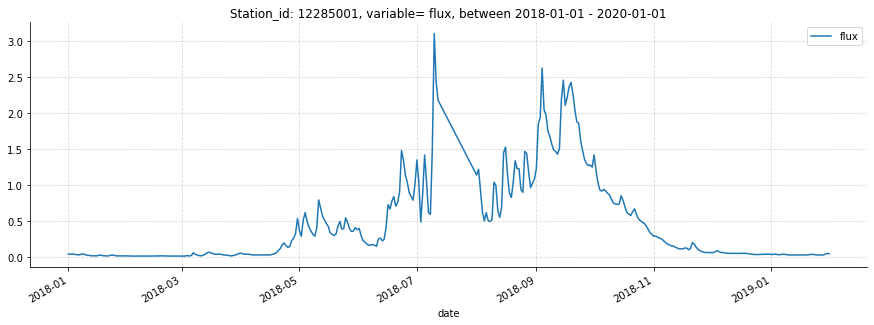

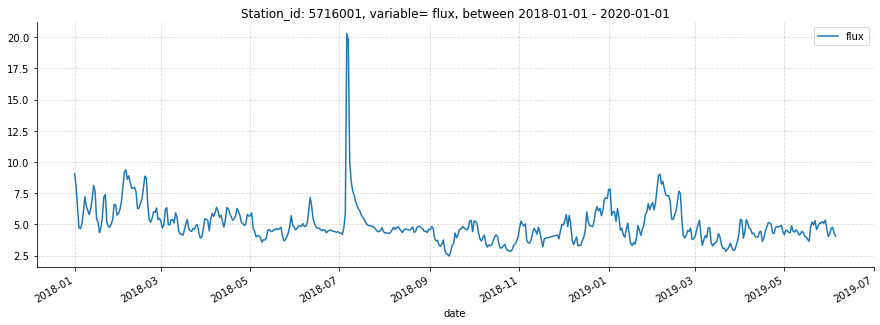

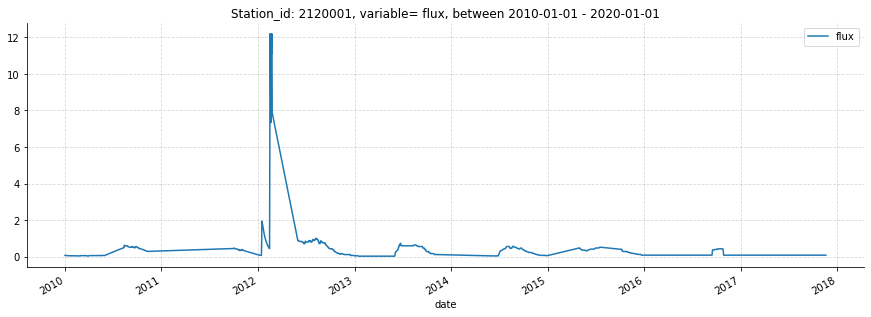

In [161]:
plot_one_timeseries(12285001, "flux", "2018-01-01", "2020-01-01")
plot_one_timeseries(5716001, "flux", "2018-01-01", "2020-01-01")
plot_one_timeseries(2120001, "flux", "2010-01-01", "2020-01-01") #To check

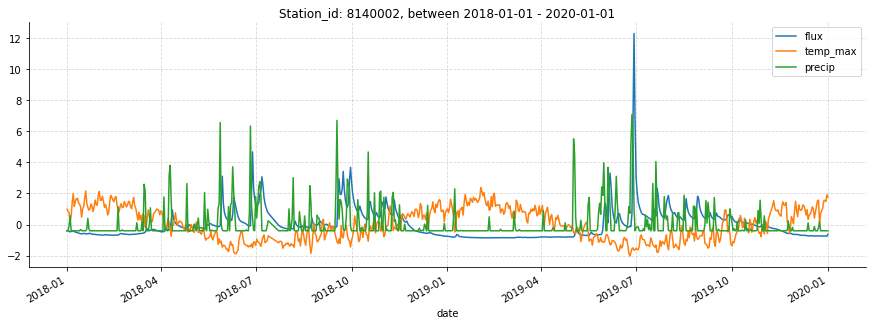

In [162]:
plot_three_timeseries(8140002, "2018-01-01", "2020-01-01")

## 4) Create three variables 

In [163]:
seasons = [
    ("spring", (dt.date(2000, 9, 23), dt.date(2000, 12, 21))),
    ("summer", (dt.date(2000, 12, 21), dt.date(2000, 12, 31))),
    ("summer", (dt.date(2000, 1, 1), dt.date(2000, 3, 20))),
    ("autumn", (dt.date(2000, 3, 20), dt.date(2000, 6, 21))),
    ("winter", (dt.date(2000, 6, 21), dt.date(2000, 9, 23))),
]

In [85]:
def _compute_seasson(date: dt.datetime) -> str:

    date = date.replace(year = 2000)
    for season, (lower_int, upper_int) in seasons:
        if lower_int <= date < upper_int:
            return season

def _over_95(series: pd.Series) -> pd.Series:

    threshold= series.quantile(0.95)
    return np.where(series > threshold, 1, 0)


def compute_extreme_metrics(data: pd.DataFrame) -> pd.DataFrame:

    data["seasons"] =  data.date.dt.date.apply(lambda x: _compute_seasson(x))
    data[["flux_extreme", "temp_extreme", "precip_extreme"]] = (
        data
        .groupby(["seasons", "basin_id"])[["flux", "temp_max", "precip"]]
        .transform(_over_95)
        )

    return data

In [86]:
data = compute_extreme_metrics(data)

In [87]:
print(f"{data.flux_extreme.mean():.2%} flux are extreme")

4.97% flux are extreme


We are faced with an unbalanced dataset, it is important to take this into account when creating the model and transforming variables.

#### Do you consider this a good way of capturing extreme events? Or you would have used a different method? Which one?

Yes, it is a correct way to find the extreme events considering seasonality at a seasonal level. However, a 4-month period may still be too long to explain seasonality by itself, especially when considering the months between seasons, where the behavior is not necessarily similar to what is expected.

## 5) Plot flux extreme

In [88]:
flux_extreme_series = pd.pivot_table(data, values= "flux_extreme", index= "basin_id", columns= pd.Grouper(key= "date", freq= "YS"), aggfunc="sum")

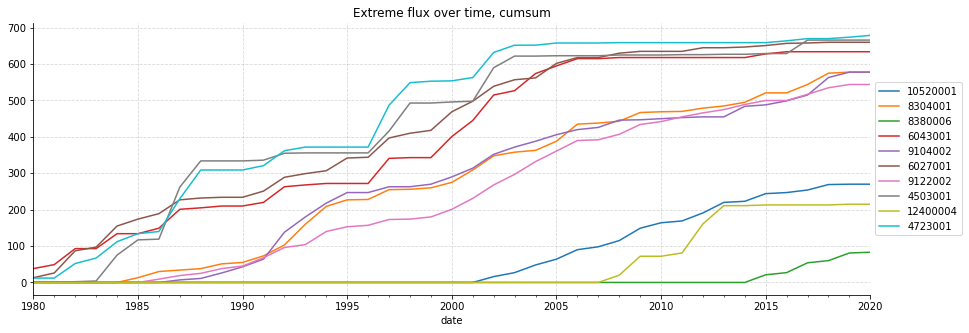

In [169]:
SAMPLE_PLOT = 10

flux_extreme_series.fillna(0).cumsum(axis=1).sample(SAMPLE_PLOT).T.plot(figsize=(15,5))
plt.legend(loc= "center left", bbox_to_anchor= (1, 0.5))
plt.grid(color="grey", alpha= 0.3, linestyle= "--")
plt.title("Extreme flux over time, cumsum")
sns.despine()

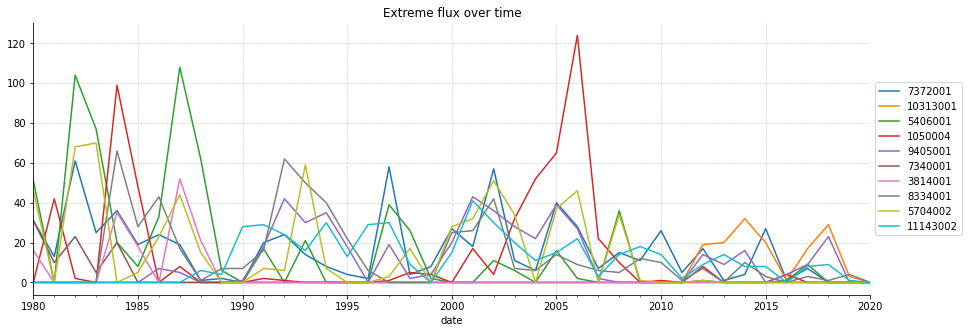

In [168]:
flux_extreme_series.fillna(0).sample(SAMPLE_PLOT).T.plot(figsize=(15,5))
plt.legend(loc= "center left", bbox_to_anchor= (1, 0.5))
plt.grid(color="grey", alpha= 0.3, linestyle= "--")
plt.title("Extreme flux over time")
sns.despine()

#### Are there any different behaviours among different watersheds?

Indeed, there are significant differences in the behavior of different basins, varying in their frequency and in the propensity of each one to one of these extreme events. On the other hand, it is also true that if we consider a considerable number of curves representing the accumulated extreme events for each basin, we can observe a pattern that could suggest that there are some basins with similar behavior and that could eventually be used as a proxy to know the future behavior of other unmeasured basins.

To validate this hypothesis, a deeper analysis is needed, for example, by making clusters of time series to calculate similarities, which is beyond the scope of this challenge.


## 6) Plot the percentage of extreme

In [91]:
extreme_events = ["flux_extreme", "temp_extreme", "precip_extreme"]

extreme_events_pct = data.groupby(pd.Grouper(key="date", freq= "YS"))[extreme_events].mean()

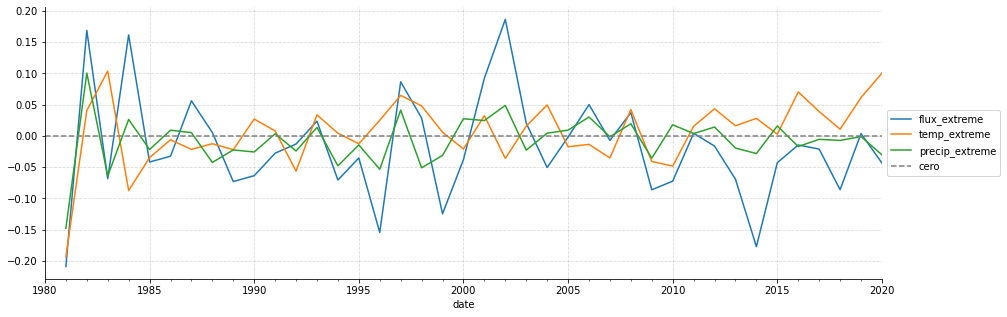

In [166]:
extreme_events_pct.rolling(min_periods=0, window=12).mean().pct_change().plot(figsize=(15,5))
plt.axhline(0, color= "gray", linestyle= "--", label= "cero")
plt.legend(loc= "center left", bbox_to_anchor= (1, 0.5))
plt.grid(color="grey", alpha= 0.3, linestyle= "--")
sns.despine()

### Have they become more frequent?

When analyzing the moving average curve of the last year for the extreme events, calculating its percentage difference and comparing it visually with the horizontal linear one that marks the zero. It can be seen that although the curves oscillate around zero, it can be clearly seen that from approximately 2010 onwards, this behavior changes and the curves show a trend, in the case of extreme precipitation and extreme flux, they remain below zero, which indicates a downward trend in this type of event.

On the other hand, the temperature shows a sustained trend above the zero point, indicating that extreme temperature events are becoming more common, tending to increase in recent years.


## 7) Feature engineering and modeling

In [93]:
data.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,seasons,flux_extreme,temp_extreme,precip_extreme
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,0.0,0.0,0.0
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,0.0,0.0,0.0
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,0.0,0.0,0.0
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,0.0,0.0,0.0
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,0.0,1.0,0.0


In [123]:
def get_features(data: pd.DataFrame, window_agg: List[str] = ["7d", "15d", "30d"]) -> Tuple[pd.DataFrame, List[str]]:
    """ Process the features to be used in the final model
    
    Parameters
    ----------
    data: pd.DataFrame
        raw database
        
    windw_agg: List[str]
        list with the desire windows to perform agregation
        
    Returns
    ----------
    Tuple[pd.DataFrame, List[str]]
        DataFrame with the data and a list with all the categorical variables
    """

    #Categorical 

    categorical_variables = [
        "lon_dec",
        "lat_dec", 
        "km2_dec", 
        "elev_dec", 
        "gauge_type",
        "month", 
        "week", 
        "day", 
        "seasons"
    ]
    
    label_encoder_gauge = LabelEncoder()
    label_encoder_season = LabelEncoder()
    
    data["lon_dec"] = pd.qcut(data.lon, 10, labels= range(10))
    data["lat_dec"] = pd.qcut(data.lat, 10, labels= range(10))

    data["km2_dec"] = pd.qcut(data.area_km2, 10, labels= range(10))
    data["elev_dec"] = pd.qcut(data.mean_elev, 10, labels= range(10))

    data["gauge_type"] = label_encoder_gauge.fit_transform(data.gauge_name.str.split(" ").str[0])

    data["month"] = data.date.dt.month
    data["week"] = data.date.dt.week
    data["day"] = data.date.dt.day

    data["seasons"] = label_encoder_season.fit_transform(data.seasons)
    
    # basin_id and seasons

    # Continous 

    continous_features = [
        "basin_id", 
        "date",
        "flux", 
        "precip", 
        "temp_max", 
        "temp_extreme",
        "precip_extreme",
        "flux_extreme", 
    ]

    for window in window_agg:
        tmp_table = data.groupby("basin_id")[["date", "flux", "temp_max", "precip", "precip_extreme", "temp_extreme"]].rolling(window, min_periods=1, on="date").mean()
        data = data.merge(tmp_table, how="left", on= ["basin_id", "date"], suffixes=("", f"_{window}"))
        continous_features.extend([x+f"_{window}" for x in ["flux", "temp_max", "precip"]])


    all_features = continous_features + categorical_variables
    data = data[all_features]
    data["target"] = data[["basin_id", "date", "flux_extreme"]].sort_values("date", ascending=True).groupby("basin_id")["flux_extreme"].transform(lambda x: x.shift(-1))

    return data.drop(columns= ["flux_extreme"]), categorical_variables


In [97]:
process_data, cat_variables = get_features(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [98]:
process_data.dropna(subset=["target"], inplace= True)

In [99]:
train = []
test = []

for bas_id, data in process_data.groupby("basin_id"):  

    tmp_data = data.sort_values("date", ascending=True)
    train.append(tmp_data.iloc[:-40,:])
    test.append(tmp_data.iloc[-40:,:])

In [100]:
df_test = pd.concat(test, axis=0)
df_train = pd.concat(train, axis=0)

In [101]:
X_test, y_test = df_test.drop(columns=["target", "basin_id", "date"]), df_test.target
X_train, y_train = df_train.drop(columns=["target", "basin_id", "date"]), df_train.target

The selected model is LightGBM due to its good performance in most of the situations, in addition to the flexibility it provides, both in the treatment of unbalanced data and in the easy handling of categorical variables. It is worth mentioning that given the nature of the model (tree-based) it is not necessary to scale the variables for a better performance of the model (as it happens, for example, with neural networks).

In [112]:
clf = lgb.LGBMClassifier(is_unbalance= True)
clf.fit(X_train, y_train, categorical_feature= cat_variables)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(is_unbalance=True)

In [119]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93   3937207
         1.0       0.27      0.90      0.41    205926

    accuracy                           0.87   4143133
   macro avg       0.63      0.89      0.67   4143133
weighted avg       0.96      0.87      0.90   4143133



In [118]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     19167
         1.0       0.28      0.84      0.42       953

    accuracy                           0.89     20120
   macro avg       0.63      0.87      0.68     20120
weighted avg       0.96      0.89      0.91     20120



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

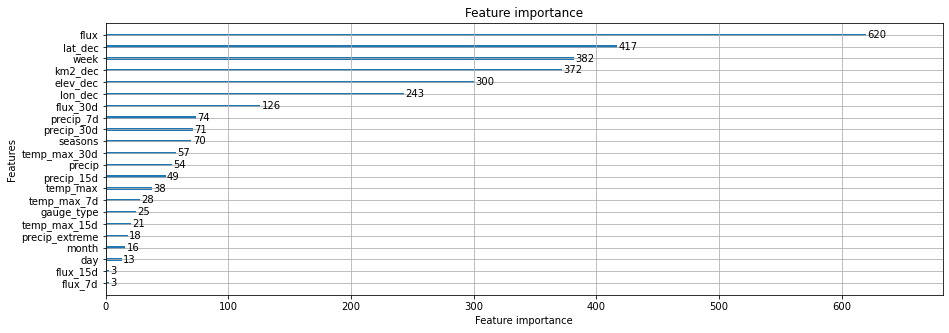

In [122]:
lgb.plot_importance(clf, figsize= (15,5))

It is important to make a good separation of data, conscious and consistent with the dates used. When working with time series it is not correct to perform a random split, because what we need is to predict in the future, using past data, which would not necessarily be fulfilled by random sampling.

In addition, this gives us a more realistic notion of the performance of our model, because for testing we will use data that the model has not actually seen and that are in a time window later than the data used in the training (analogous to the proposed use of the model in production).

To generate the target, next day data are considered, i.e. the objective of the model is to predict if tomorrow there will be an extreme flux event. We will use features built from the available variables, generating new features, on the side of the proposed categorical variables, the latitutes, lengths, areas and elevations (generating bins), with the dates, generating periods that will try to capture the temporality of the events (weeks, days of the year, month of the year and season of the year). 

On the other hand, for the continuous variables the data of flux day, precipitation and maximum temperatures will be kept, adding data of extreme maximum temperature and extreme precipitation previously constructed, plus historical information added as an aggregation in windows of 7, 15 and 30 days.

Needless to say, variables that are not available in the "present" cannot be added as variables to the model, since this situation would result in a leakage of information that would distort the model results.

## 8) Analyze the model results

#### a) What is the performance of the model? Which metrics you consider are the best suited for this problem? What are the most important variables? What do you think about the results?

For this problem, without any doubt the most important metric is the recall over the extreme flux case, since we are facing a problem with a significant imbalance, it is necessary to correctly establish the thresholds to meet our specific objective, which should tend to be able to identify or predict as many extreme events as possible, even if we run the risk of having erroneous predictions in many cases.

This is especially important if we think about the serious consequences of an extreme flux event and the associated costs. In this particular case, the phrase "prevention is better than cure" applies.

The results are as expected, with very good results for the majority class and quite good results for the extreme flux case. I think it has to do with the fact that although they are extreme events, given the time window being considered (1 day) it is very small and it may be that a day before there are clear signs that this event may occur or that it may last more than 1 day, so given that today there is a flood, it is very likely that tomorrow it will continue.

The most important variable for this model is the flux itself, as already mentioned this may be related to the short period to be predicted in conjunction with the average duration of these extreme events.

On the other hand, data related to the geography of the basins are also very relevant, as longitude, latitude, elevation and surface are relevant when making the prediction, which suggests that in order to improve the model, perhaps data that provide more information about the terrain, its conditions and changes prior to these events should be prioritized.

#### b) If we wanted to identify at least 70% of the extreme flux events, which are the metrics of your model for that threshold? It is a useful model?

If we want to identify at least 70% of the extreme fluxes, we must look at the recall of the model for the minority class. The developed model complies with the necessary standards, having a recall of 84% over the test group (proxy of reality).

#### Considerations

If more hours had been dedicated to the analysis of the problem, it would have been interesting to delve deeper into the engineering of features with the objective of maximizing the use of the available information, looking for the best model. In addition, tests would have been performed with different models and a hyperparameter optimization would have been performed, using a framework such as optuna.

On the other hand, it would have been interesting to analyze the importance of the variables using SHAP or a similar methodology (Anchor for example) to try to explain more in depth the predictions of the model and generate discussion about the most important variables when predicting these extreme events, also seeking to generate knowledge about this natural phenomenon.